## Setting up: 

In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
# importing the module
import json

%load_ext autoreload
%autoreload 2

#additional functions:
from add_functions.proj1_helpers import *
from add_functions.ml_methods_labs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

Note: 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [5]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [6]:
print(f'training data shape: y {y.shape}, X {tX.shape}')

training data shape: y (250000,), X (250000, 30)


In [7]:
### standardize data:
tX_std = standardize(tX)

#check if standardization method correct:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(tX)
#print(scaler.transform(tX))

StandardScaler()

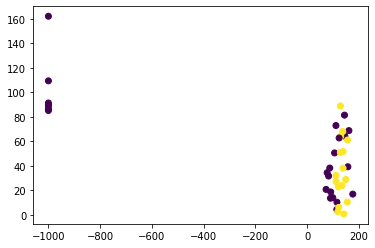

In [8]:
#Plot a few samples of first two coordinates:
NUM_POINTS = 40
plt.scatter(tX[:NUM_POINTS, 0], tX[:NUM_POINTS, 1], c=y[:NUM_POINTS])

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Least Squares GD: 
Linear regression using gradient descent. 

In [94]:
def gradient_MSE(y, tx, w):
    return (-1 / len(y)) * tx.T @ (y - tx @ w)

In [97]:
def MSE_loss(y, tx, w):
    MSE = np.square(np.subtract(y, tx @ w)).mean()
    return MSE

In [98]:
def update_weights_LS_GD(tX, y, w, parameters):
    # get parameters:
    lr = parameters['lr']
    grad = gradient_MSE(y, tX, w)
    w -= lr * grad
    return w

### Least Squares SGD:
Linear regression using stochastic gradient descent

In [99]:
def update_weights_LS_SGD(tX, y, w, parameters):
    # get parameters:
    lr = parameters['lr']
    batch_size = parameters['batch_size']

    for minibatch_y, minibatch_tx in batch_iter(y, tX, batch_size):
        grad = gradient_MSE(minibatch_y, minibatch_tx, w)
        w -= lr * grad
    return w

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [102]:
def least_squares(tX_train, y_train, tX_val, y_val):
    # "train": 
    w = np.linalg.solve(tX_train.T @ tX_train, tX_train.T @ y_train)
    
    # evaluate loss on validation set:
    loss = MSE_loss(y_val, tX_val, w)
    return w, loss

### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [103]:
def ridge_regression(tX_train, y_train, tX_val, y_val, parameters):
    # get parameters:
    lambda_ = parameters['lambda_']
    
    # "train": 
    w = np.linalg.solve(
        tX_train.T @ tX_train + lambda_ * np.eye(tX_train.shape[1]),
        tX_train.T @ y_train)
    
    # evaluate loss on validation set:
    loss = MSE_loss(y_val, tX_val, w)
    return w, loss

### Logistic (regularized) regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

- cost : $J(w) = -1/m (-y^T log (h)-(1-y)^T log (1-h)) + \lambda/(2m)||w||^2 ; h = sigmoid(Xw)$

Regularized logistic regression using gradient descent or SGD. $ w^* = min_w \sum_{i=1}^n log(1+exp(-y_i w^T x_i)) +\lambda ‖w‖^2$

In [111]:
def sigmoid_activation(z):
    return 1.0 / (1.0 + np.exp(-z))

In [112]:
def cost_logistic(tX, y, w, parameters):
    # get parameters:
    lambda_ = parameters['lambda_']
    
    predictions = sigmoid_activation(tX @ w)
    m = y.shape[0]
    
    #Take the sum of both costs: error when label=1 + error when label=0
    cost = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    
    #Take the average cost:
    cost = cost.sum() / m

    # regularizer:
    if lambda_:
        cost += (lambda_ / (2 * m)) * w.T @ w
    return cost

In [113]:
def update_weights_logistic(tX, y, w, parameters):
    # get parameters:
    lr = parameters['lr']
    lambda_ = parameters['lambda_']
    m = len(tX)
    
    #Get Predictions:
    predictions = sigmoid_activation(np.dot(tX, w))
    
    # slope of the cost function across all observations
    gradient = (tX.T @ (predictions - y))

    # if regularization
    if lambda_:
        gradient += lambda_ * w
    
    gradient /= m
    
    # Subtract from our weights to minimize cost
    w -= lr * gradient
    return w

## k-fold cross validation and hyperparameter tuning: 

In [114]:
def cross_validation_sets(tX, y, percentage):
    tX = pd.DataFrame(tX_std)
    y = pd.DataFrame(y)
    indices = tX.index.values

    #select a percentage of random rows random rows
    train_indices = np.random.choice(range(0, indices[-1]),
                                     size=int(indices[-1] * percentage),
                                     replace=False)
    tX_train = tX.iloc[train_indices].values
    tX_val = tX.drop(index=train_indices, axis=0).values
    y_train = y.iloc[train_indices].values[:, 0]
    y_val = y.drop(index=train_indices, axis=0).values[:, 0]
    
    assert (tX_train.shape[0] + tX_val.shape[0] == len(tX.index.values))
    assert (y_train.shape[0] + y_val.shape[0] == len(tX.index.values))

    return tX_train, y_train, tX_val, y_val

In [116]:
models = {
    'LS_GD': 'Least squares with GD',
    'LS_SGD': 'Least squares with SGD',
    'LS_normal': 'Least squares with normal equations',
    'RR_normal': 'Ridge regression with normal equations',
    'LR': 'Logistic regression with GD',
}

In [135]:
def train_model(model, parameters):
    weights = []
    loss = []

    PERCENTAGE = parameters['perc']
    K = parameters['K']

    MAX_ITERS = parameters['max_iters']
    costs_ = np.zeros([K, MAX_ITERS])
    initial_w = np.zeros(tX_std.shape[1])

    print(
        f'{models[model]} starting with: \nInitial_w: {initial_w},\nParameters:{parameters}'
    )
    print('------------------')
    print('START TRAINING:')

    for i in range(K):
        print(f'K = {i+1}')
        tX_train, y_train, tX_val, y_val = cross_validation_sets(
            tX_std, y, PERCENTAGE)

        #initial_w
        w = initial_w.copy()
        cost_history = []

        if model == 'RR_normal':
            w, cost_history = ridge_regression(tX_train, y_train, tX_val,
                                               y_val, parameters)
        if model == 'LS_normal':
            w, cost_history = least_squares(tX_train, y_train, tX_val, y_val)
            print(cost_history)

        else:
            for j in range(MAX_ITERS):
                # Calculate error on validation:

                if model == 'LR':
                    # calculate loss:
                    cost = cost_logistic(tX_val, y_val, w, parameters)
                    cost_history.append(cost)
                    # Update weights of model on train:
                    w = update_weights_logistic(tX_train, y_train, w,
                                                parameters)

                if model == 'LS_GD':
                    #calulate loss:
                    cost = MSE_loss(y_val, tX_val, w)
                    cost_history.append(cost)
                    # update weights:
                    w = update_weights_LS_GD(tX_train, y_train, w, parameters)
                if model == 'LS_SGD':
                    #calulate loss:
                    cost = MSE_loss(y_val, tX_val, w)
                    cost_history.append(cost)
                    # update weights:
                    w = update_weights_LS_SGD(tX_train, y_train, w, parameters)

            print(f'Final loss:{cost}')
            #print(f'Final weights:{w}')

            # Add last weights and loss for auditing:
        weights.append(w)
        loss.append(cost)
        costs_[i] = cost_history
        print('------------------')

    print('Average loss: {avg_loss}'.format(avg_loss=np.mean(loss)))
    
    best_w = weights[np.argmin(loss)]
    
    # Plot loss evolution:
    if model != 'LS_normal' and model != 'RR_normal':
        print('------------------')
        print('Loss evolution:')
        plt.plot(costs_.T)
        plt.title(models[model])
        plt.legend(range(1, K + 1))
    
    return best_w, np.mean(loss)

Logistic regression with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.02, 'lr': 0.01, 'max_iters': 100, 'perc': 0.8, 'K': 5}
------------------
START TRAINING:
K = 1
Final loss:0.4663330390451621
------------------
K = 2
Final loss:0.46399860429431544
------------------
K = 3
Final loss:0.4596484969208305
------------------
K = 4
Final loss:0.46648863979907573
------------------
K = 5
Final loss:0.4672679544662607
------------------
Average loss: 0.4647473469051289
------------------
Loss evolution:


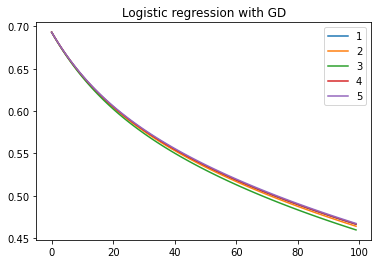

In [136]:
## Training with k-fold:
model = 'LR'
with open('parameters.json') as json_file:
    data = json.load(json_file)
    parameters = data[model]
    
best_w, avg_loss = train_model(model, parameters)

## Generate predictions and save ouput in csv format for submission:

In [137]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

test data shape: X (568238, 30)


In [138]:
# standard par rapport à moyenne et std de train:
mean_train = np.mean(tX, axis=0)
std_train = np.std(tX - mean_train, axis=0)
test_data = standardize_with_meanstd(tX_test, mean_train, std_train)

In [145]:
# Choose method: 
from datetime import date
today = date.today()

test_prediction = predict_labels(best_w, test_data)
OUTPUT_PATH = '../data/results/y_pred_' + model + '_'+str(today)+'.csv'
ids_test = pd.read_csv('../data/sample-submission.csv')['Id']
create_csv_submission(ids_test, test_prediction, OUTPUT_PATH)